<a href="https://colab.research.google.com/github/zangatec/4055_team50/blob/main/TC5033_Activity1b_Team50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033

#MNA - Advance Machine Learning Methods.

Miguel Angel Muriola Medina       01794830

Ignacio Alonso Martínez Sevilla   00997434

Omar Mexía Barraza                01794780

Pedro Ulises Meléndez Ortega      00716301


## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
#DATA_PATH = 'https://drive.google.com/file/d/168t4kGtYDeN3UPaNe1Y2I5Sr2L73U8rc/uc?export=download'
DATA_PATH = '/content/drive/MyDrive/asl_data'
#!gdown --id 1xq6ez1e8vglBICODubGMj2nCWY8JxLjj
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))

#!gdown --id 13sr3YyN8JlLenDguxUgHYSghUiCgZ7Iz
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [4]:
df=train_df.copy()

In [5]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
print (df.shape)

(27455, 785)


### Importar Images

In [7]:
y_train = np.array(train_df['label'])               #Label indicates the y value
y_val = np.array(valid_df['label'])                 #Label indicates the y value
del train_df['label']                               #For the image pixels we don't require the y
del valid_df['label']                               #For the image pixels we don't require the y
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [8]:
# In this section we define the split, for this we decided to just split the data based on an index predefined by the pct. Allthough there is a shuffle, given that we have no previous information, we assume the images are already shuffled.

def split_val_test(x, y, pct=0.5, shuffle=True):
    split_index = int(len(x) * pct)
    x_val = x[split_index:]
    y_val = y[split_index:]

    x_test = x[:split_index]
    y_test = y[:split_index]
    return x_val, y_val, x_test, y_test

In [9]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

Normalization

In [10]:
# Normalization function to improve results, given that NN work better with normalized data
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

x_mean = x_train.mean()
x_std = x_train.std()

# Here it is important to note that all data is being scaled using the training data mean and standard deviation in order to avoid contamination.
x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [11]:
### The following just inports the alphabet.

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


Plot Samples.
 Since there are 784 columns + label. We have a 28x28 pixel image.


In [12]:
print (df.shape)

(27455, 785)


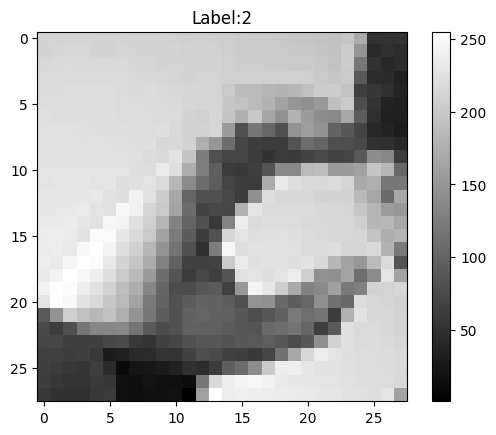

In [19]:

fila_index = 3
label=df.iloc[fila_index,0]
pixels = df.iloc[fila_index,1:].values
image = pixels.reshape((28, 28))

plt.imshow(image, cmap='gray')
plt.title(f"Label:{label}")
plt.colorbar()
plt.show()

We can see that the data set is about classificaction of alphabet letters using sign language

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [ ]:
#The creation of mini batches is usually done to increase training speed as the algorighm looks into smaller sample sizes that are less resource intensive.

def create_minibatches(mb_size, x, y,shuffle = True):

    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [ ]:
class np_tensor(np.ndarray): pass   #This allows us to create atributes to the np_tensor which is an array later on

a = np.array([0, 0])
b = a.view(np_tensor)
type(a)
type(b)
a == b
a is b

False

## Nuestra clase Linear, ReLU y Sequential

###  Clase Linear

In [ ]:
class Linear():
    def __init__(self, input_size, output_size):                                                        #This is the initialization of the function, input_size is the amount of elements in the previous layer, output size is the amount of neurons defined for this layer.
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)     #Define random weights as a startin point based on Kaiming He, where the weights are based on the current and previous layers amount of neurons.
        self.b = (np.zeros((output_size, 1))).view(np_tensor)                                           # Initiates as zeroes in one column
    def __call__(self, X):                                                                              # Forward pass
        Z = self.W @ X + self.b                                                                         # This equals to Wx+b
        return Z

    def backward(self, X, Z):                                                                           #Backward pass, X is the # of entrances, Z the # of outputs
        X.grad = self.W.T @ Z.grad                                                                      # Gradient X is The gradient times the Weights (Weights are transposed to comply with matrix multiplication)
        self.W.grad = Z.grad @ X.T                                                                      # Gradient for the Weights
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)                                           # Gradient for the bias


### Clase ReLU

In [ ]:
class ReLU():
    def __call__(self, Z):              #We obtain Z which is the result of Wx+b
        return np.maximum(0, Z)         # What ever Z value is bellow 0 we have a 0 and if the value is bigger than 0 it will as as is.
    def backward(self, Z, A):
        Z.grad = A.grad.copy()          #we copy the gradient of A to Z
        Z.grad[Z <= 0] = 0              # We check if the values are bellow or above 0, if it is bellow zero, the value is 0

### Clase Sequential

In [ ]:
class Sequential_layers():
    def __init__(self, layers):
        self.layers = layers                                                                    # Here we have the amount of layers
        self.x = None                                                                           # x stores all the z value activations of the neurons (It is kind of a ram memory)
        self.outputs = {}                                                                       # This dictionaries stores the activations to later calculate backward pass (Kind of a ROM memory)
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x                                                             # The first elements are the inputs
        for i, layer in enumerate(self.layers, 1):                                              # For loop where we go through all the layers inside, either Linear, Relu or what ever you have defined before
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x                                                     # Save elements in outputs
        return self.x
    def backward(self):                                                                         # Enables backward pass
        for i in reversed(range(len(self.layers))):                                             # Loops through all the layers on a backward sequence
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])       # On the first part we store the outputs of the current layer and then the outputs of the previous layer
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:                                                               # Loop that helps us go through all the layers
            if isinstance(layer, ReLU): continue                                                # Since Relu doesn't have tunable parameters we can omit it with this if
            layer.W = layer.W - learning_rate * layer.W.grad                                    # We call the current W weight and then reduce it by the W gradient times the learning rate.
            layer.b = layer.b - learning_rate * layer.b.grad                                    # We call the current b bias and then reduce it by the b gradient times the learning rate.
    def predict(self, X):
        return np.argmax(self.__call__(X))                                                      # Returns the index with the highest scores (Final Predicted y value)

### Cost Function

In [ ]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]                             # Gets the size
    exp_scores = np.exp(x)                              # gets the scores
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]   #Gets the scores
    cost = np.sum(-np.log(y_hat)) / batch_size          #Calculate the costs  by getting the logarithm of the preduction over the batch size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1      #For all the correct values we substract a 1 due to yhat-y
    x.grad = probs.copy()

    return preds, cost

### Accuracy

In [ ]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):      # Cicle through the mini batches
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())       # Add 1 for all the predicted values that are correct
        total += pred.shape[1]                                          # Count all the values
    return correct/total                                                # Divide correct values over all the values

### Loop de entrenamiento

In [ ]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):                                                                 # Loop that goes through epochs
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):              # We define minibatch size as mb_size, X values and y values and run through all the mini batches
            scores = model(x.T.view(np_tensor))                                                 # we require to pass x values as a tensor so that it gets stored for gradient calculation
            _, cost = softmaxXEntropy(scores, y)                                                # Run the cost portion
            model.backward()                                                                    # Run the backward portion
            model.update(learning_rate)                                                         # Run the learning rate where values are adjusted accordingly
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')                    # Print the current cost and accuracy of the model for a quick assesment


### Create your model and train it

In [ ]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 10)])
mb_size = 15
learning_rate = 1e-3
epochs = 50

train(model, epochs, mb_size, learning_rate)


IndexError: index 15 is out of bounds for axis 0 with size 10

### Test your model on Random data from your test set

In [ ]:
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es:{alphabet[y_test[idx]]}')

NameError: name 'plot_number' is not defined